# Домашнее задание
- Выберите ряд, на котором происходит аномалия. Примените к нему все 4 способа поиска анамолий

In [19]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import boxcox

from collections import deque

In [8]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
        
    return

In [3]:
#Исходный ряд (тот же, что и в предыдущих ДЗ)
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


D:\Program_Files\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


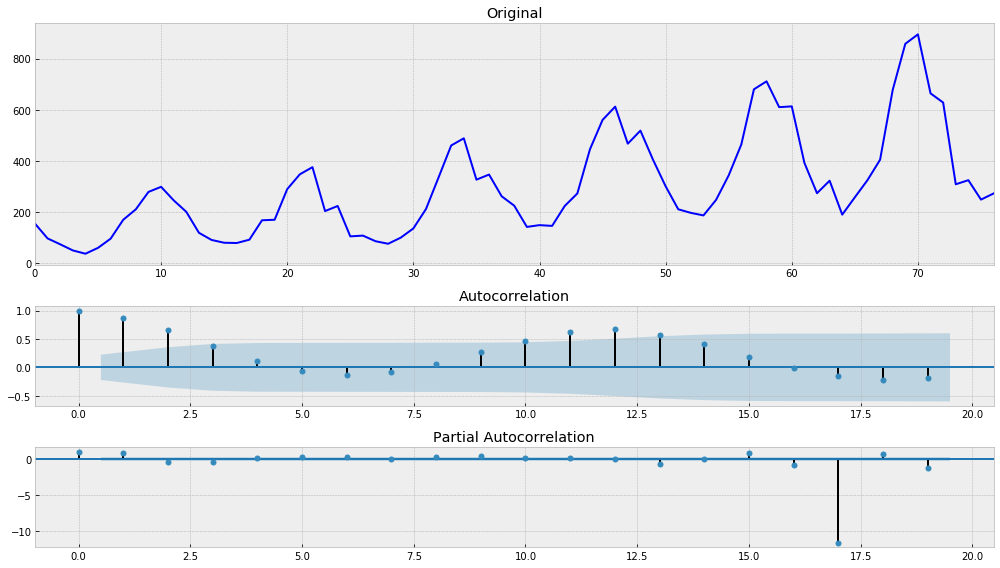

In [9]:
tsplot(series)

### 1. Простое мат ожидание

In [4]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [11]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(10,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

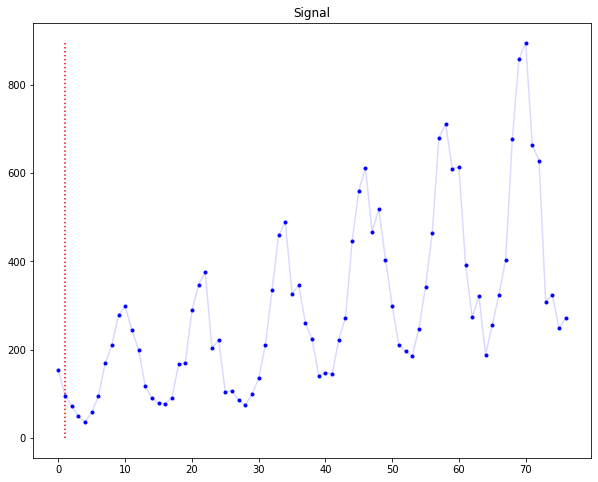

In [12]:
# для исходного ряда
simulate(MeanDetector(), series)

In [13]:
# для диффиренцированного ряда
series_dif = np.diff(series, 3)

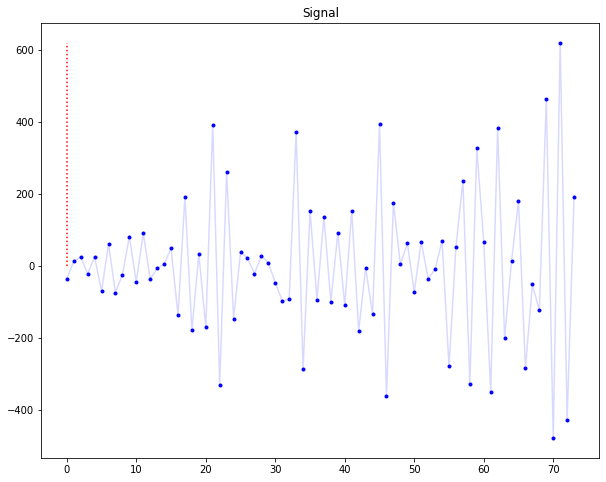

In [14]:
simulate(MeanDetector(), series_dif)

Результат был немного предсказуем

### 2. Zscore

In [17]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

D:\Program_Files\Anaconda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
D:\Program_Files\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


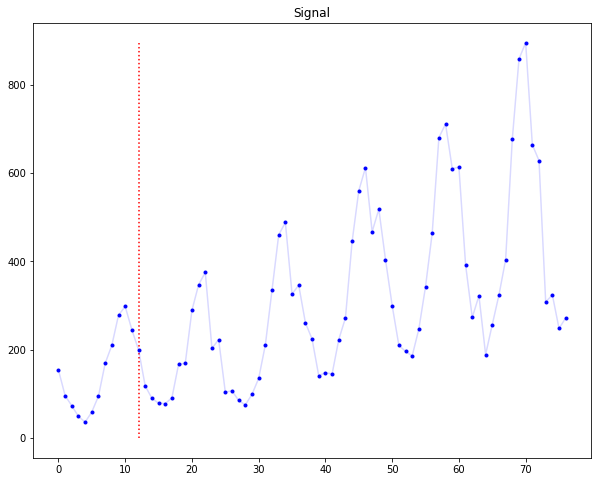

In [33]:
# исходный ряд
simulate(ZScoreDetector(window_size= 10, threshold=0.20), series)

D:\Program_Files\Anaconda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
D:\Program_Files\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


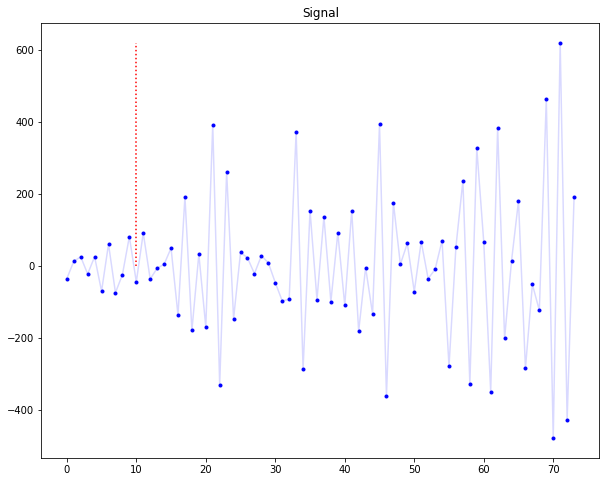

In [34]:
simulate(ZScoreDetector(window_size= 10, threshold=0.10), series_dif)

### 3. Кумулятивные суммы

In [35]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

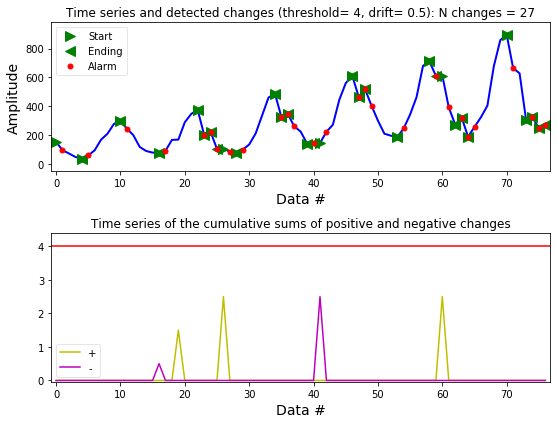

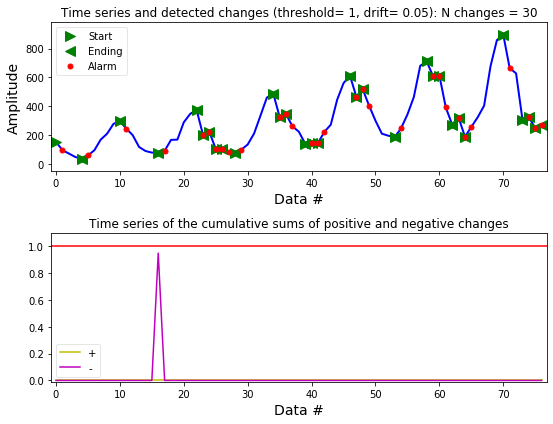

In [43]:
#Исходный ряд
x = series
detect_cusum(x, 4, 0.5, True, True)
ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)

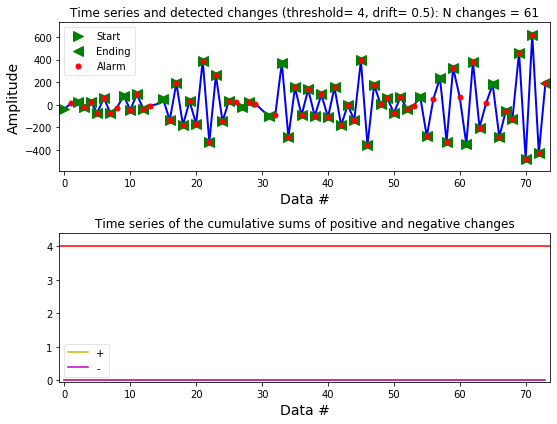

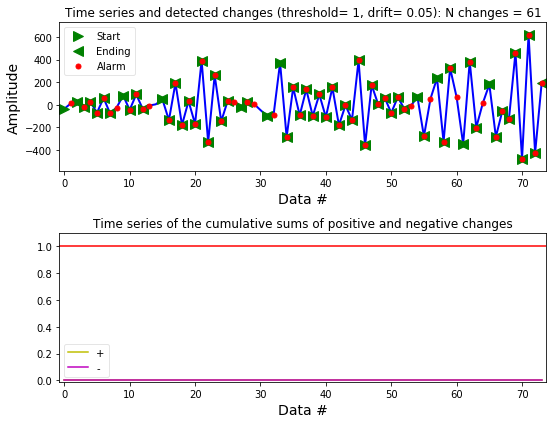

In [44]:
#Дифференцированный ряд
x = series_dif
detect_cusum(x, 4, 0.5, True, True)
ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)

### 4. OneClass SVM

In [93]:
from sklearn import svm

In [94]:
clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)

In [123]:
#Исходный ряд
series_arr = np.array(series).reshape(-1, 1)

len_series = len(series_arr)
s_perc = int(0.8 * len(series_arr)) #80% от series

clf.fit(series_arr[:s_perc])

y_pred_train = clf.predict(series_arr[:s_perc])
y_pred_test = clf.predict(series_arr[s_perc:])

In [180]:
len(series), len(series_arr)

(77, 74)

In [124]:
y = np.linspace(0, series_arr[-1], len(series_arr)).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1, 1)
Z = np.hstack((Z, Z))
y = y.reshape(len(series_arr))

In [125]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

ValueError: x and y must have same first dimension, but have shapes (1,) and (59, 1)

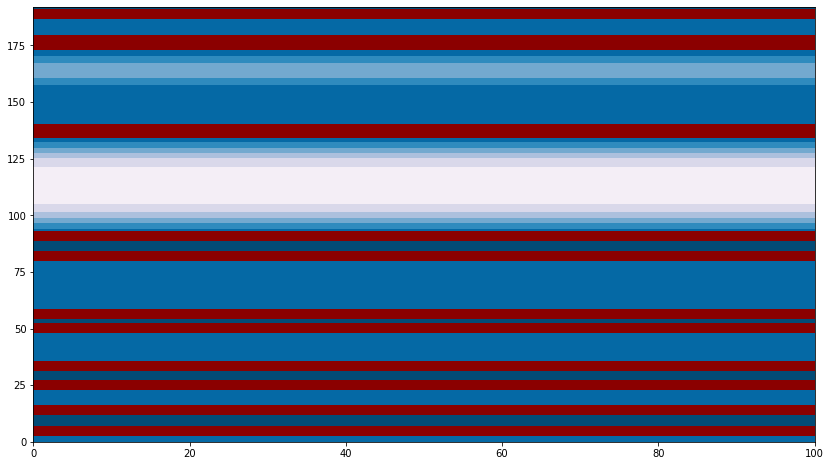

In [169]:
plt.figure(figsize=(14,8))
plt.contourf([0, 100], y, Z, cmap=plt.cm.PuBu)
plt.contour([0, 100], y, Z, levels=[0], linewidths=10, colors='darkred')

plt.plot(range(len(series_arr[s_perc])), series_arr[:s_perc], 'wo', linewidth=10)
plt.plot(range(len(series_arr[s_perc])), series_arr[:s_perc], 'w-', linewidth=2)

plt.plot(range(len(series_arr[s_perc]),100), series_arr[s_perc:], 'bo', linewidth=10)
plt.plot(range(len(series_arr[s_perc-1]),10), series_arr[s_perc+1], 'b-', linewidth=2)

plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

In [167]:
series_dif

array([ -36,   12,   25,  -23,   25,  -71,   60,  -75,  -25,   81,  -45,
         91,  -37,   -7,    4,   49, -137,  192, -180,   32, -170,  392,
       -331,  261, -147,   37,   22,  -22,   28,    8,  -47,  -98,  -93,
        372, -287,  153,  -94,  136, -100,   91, -110,  153, -182,   -5,
       -134,  393, -361,  175,    4,   62,  -72,   67,  -36,  -10,   70,
       -280,   53,  236, -328,  326,   66, -350,  383, -202,   14,  180,
       -285,  -52, -124,  463, -479,  620, -428,  192], dtype=int64)

In [142]:
#Дифференцированный ряд

series_arr = np.array(series_dif).reshape(-1, 1)
len_series = len(series_arr)
s_perc = int(0.8 * len(series_arr)) #80% от series

clf.fit(series_arr[:s_perc])

y_pred_train = clf.predict(series_arr[:s_perc])
y_pred_test = clf.predict(series_arr[s_perc:])

In [143]:
y = np.linspace(0, series_arr[-1], len(series_arr)).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1, 1)
Z = np.hstack((Z, Z))
y = y.reshape(len(series_arr))

ValueError: x and y must have same first dimension, but have shapes (91,) and (15, 1)

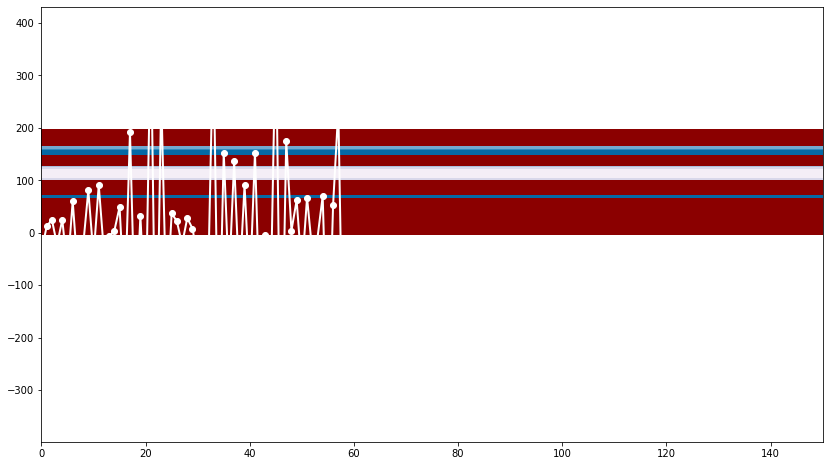

In [144]:
plt.figure(figsize=(14,8))
plt.contourf([0, 150], y, Z, cmap=plt.cm.PuBu)
plt.contour([0, 150], y, Z, levels=[0], linewidths=10, colors='darkred')

plt.plot(range(len(series_arr[:s_perc])), series_arr[:s_perc], 'wo', linewidth=10)
plt.plot(range(len(series_arr[:s_perc])), series_arr[:s_perc], 'w-', linewidth=2)

plt.plot(range(len(series_arr[:s_perc]),150), series_arr[s_perc:], 'bo', linewidth=10)
plt.plot(range(len(series_arr[:s_perc-1]),150), series_arr[s_perc-1:], 'b-', linewidth=2)

plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()